In [1]:
#Data
import pandas as pd

#Numbers and Math
import numpy as np 
import scipy.stats as stats
import statsmodels.api as sm

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from scipy.stats import pearsonr

#Graphing
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
from env import user, password, host, properties_csv, train_csv

#### Custom Functions for later use

In [3]:
def percent_zeros(df):
    cols = list(df.columns)
    zeros = {}
    for col in cols:
        zeros[col] = 'Zeros: {:.2f}%'.format((df[col] == 0).sum()/df.shape[0] * 100)
        
    return zeros

def percent_NaNs(df):
    cols = list(df.columns)
    Nans = {}
    for col in cols:
        Nans[col] = 'Missing {:0.2f}%'.format(df[col].isnull().sum()/df.shape[0]*100)
        
    return Nans

def replace_values(df,entry,orginal_value,new):
    df[entry] = df[entry].replace(orginal_value,new)
    return df

def drop_nulls_from(df,column):
    return df[df[column].notnull()]

Linear Regression Making function that returns R2 And MSE 

In [4]:
def lin_reg(xs,y):
    X_train, X_test, y_train, y_test = train_test_split(xs,y,train_size=.8)
    lm = LinearRegression()
    lm.fit(X_train,y_train)
    y_pred = lm.predict(X_test)
    values = []
    values.append(mean_squared_error(y_test,y_pred))
    values.append(r2_score(y_test,y_pred))
    return values

### Data Aquisition 

In [5]:
prop_df = pd.read_csv(properties_csv)

In [6]:
train_df = pd.read_csv(train_csv)
joint_df = pd.merge(prop_df, train_df, on='parcelid', how='inner')

In [7]:
df = joint_df[['bedroomcnt','parcelid','bathroomcnt','calculatedfinishedsquarefeet','fullbathcnt','garagecarcnt','roomcnt','yearbuilt','taxvaluedollarcnt','taxamount', 'poolcnt','poolsizesum','logerror']]

In [8]:
df.shape

(90275, 13)

### Data Exploration 

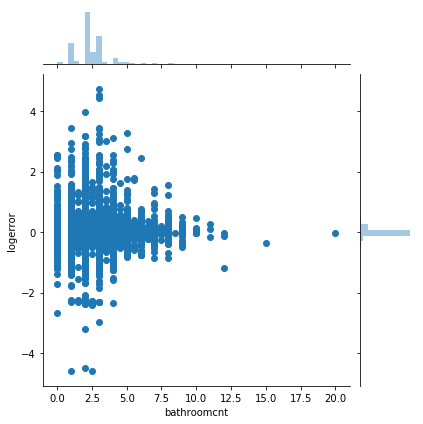

In [9]:
sns.jointplot(df['bathroomcnt'],df['logerror'])

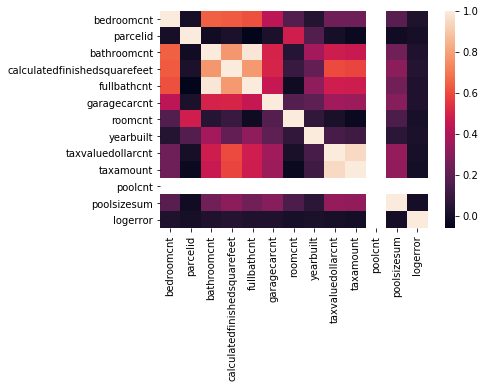

In [10]:
sns.heatmap(df.corr())

From an initial graphing look at things, it's hard to find any 1 variable that has a strong correlation with log error.

At least that seems to be true when looking at the entire set of data

Let's Check to see if there is a difference in log error if we split the sample by some basic room count checks, and see if there is a large difference in log errors. 

In [11]:
big_house = df.loc[df['bedroomcnt'] >=5]

In [12]:
lil_house = df.loc[df['bedroomcnt'] <= 2]

In [13]:
med_house = df.loc[df['bedroomcnt'] == 3]

In [14]:
stats.ttest_ind(lil_house[['logerror']], big_house[['logerror']])

Ttest_indResult(statistic=array([-7.51797047]), pvalue=array([5.6978873e-14]))

In [15]:
stats.ttest_ind(med_house[['logerror']], big_house[['logerror']])

Ttest_indResult(statistic=array([-6.60686447]), pvalue=array([3.97188197e-11]))

##### our p values are extremely small. MUCH smaller than 0.05. This means there is STRONG evidence to suggest these our Room count 5+ comes from a different population than the other DataFrames we created

### More Data Exploration

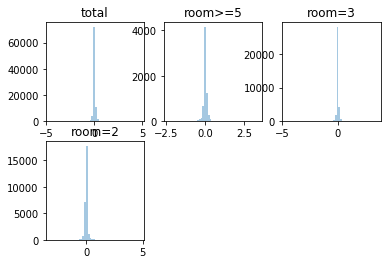

In [16]:

plt.subplot(231, title='total')
sns.distplot(df[['logerror']], kde = False)
plt.subplot(232, title='room>=5')
sns.distplot(big_house[['logerror']], kde=False, )
plt.subplot(233, title='room=3')
sns.distplot(med_house[['logerror']], kde=False)
plt.subplot(234, title='room=2')
sns.distplot(lil_house[['logerror']], kde=False)
plt.show()

We can see that the data seems to make a very tight normal distrubution for the log error no matter how we split it up. 

Let's see if we can capture info on what is driving the error with  regression models 

###  Feature Selection and Imputing 

In [17]:
df = drop_nulls_from(df, 'taxamount')
df = drop_nulls_from(df, 'taxvaluedollarcnt' )
df = replace_values(df,'garagecarcnt',np.nan,0)
df = replace_values(df,'poolcnt',np.nan,0)
df = replace_values(df,'yearbuilt',np.nan, df['yearbuilt'].mean())
df = replace_values(df,'garagecarcnt',np.nan,0)
df = replace_values(df,'calculatedfinishedsquarefeet',np.nan,0)
df = replace_values(df,'fullbathcnt',np.nan,0)

Let's replace poolcount with a variable that represents our bool as a continuous variable, but replacing all empty pool sizes with the average pool size

In [18]:
df= replace_values(df,'poolsizesum',np.nan,df['poolsizesum'].mean())
df.loc[df.poolcnt == 0, 'poolsizesum'] = 0

In [19]:
df = df.drop('poolcnt',axis=1)

#### another important thing to do is to split log error into positive and negative, to compare if different variables are affecting the positive or negative error more

In [20]:
df_p = df.loc[df['logerror'] >= 0]
df_n = df.loc[df['logerror'] <= 0]

We will follow that up by splitting these into bins based on room count like before

In [21]:
df_p_lt3 = df_p.loc[df['bedroomcnt'] <= 3]
df_p_gt3 = df_p.loc[df['bedroomcnt'] >= 3]
df_n_lt3 = df_n.loc[df['bedroomcnt'] <= 3]
df_n_gt3 = df_n.loc[df['bedroomcnt'] >= 3]

#### Let's run these dataframes through some stepwise linear regression

In [34]:
def step_wise1(df):
    lin_reg_dict = {}
    
    cols = list(df.columns)
    x_cols = cols[:-1]

    
    for col in x_cols:
        x = df[[col]]
        y = df[['logerror']]
        lin_reg_dict[col] = lin_reg(x,y)
    return lin_reg_dict

def step_wise2(df):
    lin_reg_dic = {}
    cols = list(df.columns)
    x_cols = cols[:-1]
        
    for col in x_cols:
        for col2 in x_cols:


            if col == col2:
                continue
            else:
                x = df[[col,col2]]
                y = df[['logerror']]
            colz = col+ " " + col2
            lin_reg_dic[colz] = lin_reg(x,y)
    return lin_reg_dic

def step_wise3(df):
    lin_reg_dic = {}
    cols = list(df.columns)
    x_cols = cols[:-1]
        
    for col in x_cols:
        for col2 in x_cols:
            for col3 in x_cols:
                


                if col == col2 or col == col3 or col2 == col3:
                    continue
                else:
                    x = df[[col,col2,col3]]
                    y = df[['logerror']]
                colz = col+ " " + col2 + " " + col3
                lin_reg_dic[colz] = lin_reg(x,y)
    return lin_reg_dic
    

In [23]:
our_dfs = [df_p_lt3,df_n_lt3,df_p_gt3,df_n_gt3]

In [28]:
step_wise3(df_p_lt3)

{'bedroomcnt parcelid bedroomcnt': [0.019511045757591817,
  0.004616946487484452],
 'bedroomcnt parcelid bathroomcnt': [0.02323199412407351,
  0.006659444458302133],
 'bedroomcnt parcelid calculatedfinishedsquarefeet': [0.022212534574326478,
  -0.00029804418661050214],
 'bedroomcnt parcelid fullbathcnt': [0.02221537223864939,
  0.007041080187437321],
 'bedroomcnt parcelid garagecarcnt': [0.025025659871834728,
  0.004195860445588395],
 'bedroomcnt parcelid roomcnt': [0.01744609760923083, 0.002539875147427373],
 'bedroomcnt parcelid yearbuilt': [0.02745120526122897, 0.009674438311743638],
 'bedroomcnt parcelid taxvaluedollarcnt': [0.024279257261165182,
  0.0038434480187133913],
 'bedroomcnt parcelid taxamount': [0.02187598170025246, 0.003712542860876744],
 'bedroomcnt parcelid poolsizesum': [0.022148820881530126,
  0.003057525272759265],
 'bedroomcnt bathroomcnt bedroomcnt': [0.02719695971356961,
  0.002374550904380879],
 'bedroomcnt bathroomcnt parcelid': [0.025100931944562435,
  0.0066

In [37]:
sw1_results = []
sw2_results = []
sw3_results = []
for frame in our_dfs:
    sw1_results = step_wise1(frame.drop('parcelid',axis = 1))
    sw2_results = step_wise2(frame.drop('parcelid',axis = 1))
    sw3_results.append(step_wise3(frame.drop('parcelid',axis = 1)))
    

In [33]:
sw3_results

{'bedroomcnt bathroomcnt bedroomcnt': [0.020670985046351682,
  0.0019534356892697557],
 'bedroomcnt bathroomcnt calculatedfinishedsquarefeet': [0.022921346291627617,
  1.342027210426977e-05],
 'bedroomcnt bathroomcnt fullbathcnt': [0.0168888954823441,
  0.003197721245668639],
 'bedroomcnt bathroomcnt garagecarcnt': [0.01811074841708483,
  0.007145228448205088],
 'bedroomcnt bathroomcnt roomcnt': [0.01591326379234317,
  0.0076353952341225995],
 'bedroomcnt bathroomcnt yearbuilt': [0.011322206168354568,
  0.037112727886408736],
 'bedroomcnt bathroomcnt taxvaluedollarcnt': [0.016185713114579156,
  0.006339013692038709],
 'bedroomcnt bathroomcnt taxamount': [0.015303171885025236,
  0.009270043355514845],
 'bedroomcnt bathroomcnt poolsizesum': [0.01341573994881543,
  0.0030352548178537164],
 'bedroomcnt calculatedfinishedsquarefeet bedroomcnt': [0.017077396746000527,
  0.0038483473290323866],
 'bedroomcnt calculatedfinishedsquarefeet bathroomcnt': [0.014866162796701866,
  0.0076342551021412

In [36]:
sw2_results

{'bedroomcnt bathroomcnt': [0.02462491827091735, 0.001942374044976547],
 'bedroomcnt calculatedfinishedsquarefeet': [0.018201247135519627,
  0.0032138244644295266],
 'bedroomcnt fullbathcnt': [0.019899743270843283, 0.0013410069801335078],
 'bedroomcnt garagecarcnt': [0.01996856699490971, 0.005945781011441387],
 'bedroomcnt roomcnt': [0.010682819602343682, 0.011869497686071817],
 'bedroomcnt yearbuilt': [0.015253948466436495, 0.018668969761995835],
 'bedroomcnt taxvaluedollarcnt': [0.012882906624850211, 0.009324908016053235],
 'bedroomcnt taxamount': [0.015347568256455592, 0.0073862696698742125],
 'bedroomcnt poolsizesum': [0.01928830317865635, 0.0006354568909692215],
 'bathroomcnt bedroomcnt': [0.01989735799103189, 0.0022571280263307125],
 'bathroomcnt calculatedfinishedsquarefeet': [0.018420792883787434,
  -0.0007591348489610628],
 'bathroomcnt fullbathcnt': [0.014500396939929003, 0.003042695414674501],
 'bathroomcnt garagecarcnt': [0.01578475001897476, 0.004240502929745205],
 'bathro